# project6 : 네이버 영화리뷰 감성분석 해보기

-------------------------------------------------------------------------------------------------------------

## RNN - LSTM 사용 모델

### 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
# 전체문장 길이를 알아낸 후 적절한 값을 넣는 것이 성능에 도움이 됨
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
# padding의 위치에 따라 달라질 수 있다.
# pre
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


### 4) 모델 구성 및 validation set 구성

In [7]:
# RNN 모델 설계
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [8]:
# validation set 10000건 분리
x_val = X_train[:100000]   
y_val = y_train[:100000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[100000:]  
partial_y_train = y_train[100000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(46182, 41)
(46182,)


### 5) 모델 훈련 개시

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
91/91 [==============================] - 4s 14ms/step - loss: 0.6918 - accuracy: 0.5270 - val_loss: 0.6691 - val_accuracy: 0.7649
Epoch 2/20
91/91 [==============================] - 1s 9ms/step - loss: 0.5114 - accuracy: 0.7907 - val_loss: 0.4356 - val_accuracy: 0.8191
Epoch 3/20
91/91 [==============================] - 1s 9ms/step - loss: 0.3716 - accuracy: 0.8527 - val_loss: 0.3841 - val_accuracy: 0.8344
Epoch 4/20
91/91 [==============================] - 1s 9ms/step - loss: 0.3196 - accuracy: 0.8755 - val_loss: 0.3798 - val_accuracy: 0.8343
Epoch 5/20
91/91 [==============================] - 1s 9ms/step - loss: 0.2942 - accuracy: 0.8861 - val_loss: 0.3879 - val_accuracy: 0.8336
Epoch 6/20
91/91 [==============================] - 1s 9ms/step - loss: 0.2793 - accuracy: 0.8911 - val_loss: 0.3993 - val_accuracy: 0.8307
Epoch 7/20
91/91 [==============================] - 1s 10ms/step - loss: 0.2649 - accuracy: 0.8984 - val_loss: 0.4177 - val_accuracy: 0.8290
Epoch 8/20
91/91 [

In [10]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5658 - accuracy: 0.8163
[0.565824568271637, 0.8162825107574463]


### 6) Loss, Accuracy 그래프 시각화

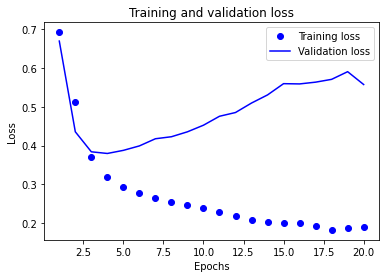

In [11]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

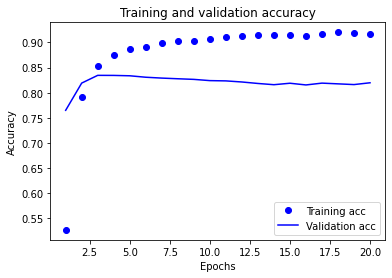

In [12]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

loss와 accuracy 모두 학습이 진행될수록 더 낮은 성능을 보이는 것을 확인할 수 있습니다.

BAD!!

여기에는 데이터가 충분히 많지 않다는 점 등 여러가지 이유가 있을 수 있습니다.

In [13]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [14]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [15]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['무서워']
vector

array([-0.00774785,  0.04811363, -0.00917961, -0.13718006, -0.07778808,
        0.12091722,  0.01531335, -0.00880755, -0.02809484, -0.04160981,
       -0.19714494,  0.00829586, -0.07917107,  0.03007822,  0.03512873,
       -0.04536895], dtype=float32)

In [16]:
word_vectors.similar_by_word("무서워")

[('구지', 0.9496662616729736),
 ('무시무시', 0.920364260673523),
 ('cg', 0.9011964201927185),
 ('1996', 0.8926936984062195),
 ('넘쳐나', 0.8878755569458008),
 ('세력', 0.8861659169197083),
 ('보성', 0.8817403316497803),
 ('나타내', 0.8721596002578735),
 ('마틴', 0.8719519972801208),
 ('19', 0.8709009885787964)]

### 8) 한국어 Word2Vec 임베딩을 활용하여 성능 개선

In [77]:
import os
import re
import urllib.request
from collections import Counter
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from konlpy.tag import Okt
from konlpy.tag import Mecab
from gensim.models import KeyedVectors, Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from utils import *
%matplotlib inline

In [78]:
word2vec_path = os.getenv('HOME') + '/aiffel/sentiment_classification/ko.bin'
word2vec = Word2Vec.load(word2vec_path)


UnpicklingError: invalid load key, '9'.

In [79]:
word2vec['추천'].shape

NameError: name 'word2vec' is not defined

In [80]:
word2vec.similar_by_word('추천')

NameError: name 'word2vec' is not defined

In [81]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

NameError: name 'word2vec' is not defined

In [82]:
# 모델 구성
maxlen = 34
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 34, 200)           2000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 32, 16)            9616      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 30, 16)            784       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 4, 16)             784       
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                

In [83]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 2s 8ms/step - loss: 0.6827 - accuracy: 0.5498 - val_loss: 0.6248 - val_accuracy: 0.6582
Epoch 2/20
188/188 [==============================] - 1s 7ms/step - loss: 0.5435 - accuracy: 0.7829 - val_loss: 0.4921 - val_accuracy: 0.8205
Epoch 3/20
188/188 [==============================] - 1s 7ms/step - loss: 0.4591 - accuracy: 0.8382 - val_loss: 0.4595 - val_accuracy: 0.8284
Epoch 4/20
188/188 [==============================] - 1s 7ms/step - loss: 0.4118 - accuracy: 0.8585 - val_loss: 0.4441 - val_accuracy: 0.8263
Epoch 5/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3757 - accuracy: 0.8734 - val_loss: 0.4192 - val_accuracy: 0.8421
Epoch 6/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3469 - accuracy: 0.8845 - val_loss: 0.4195 - val_accuracy: 0.8409
Epoch 7/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3199 - accuracy: 0.8959 - val_loss: 0.4096 - val_accuracy: 0.8404
Epoch 

In [84]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.6191 - accuracy: 0.8197


In [85]:
history_dict = history.history

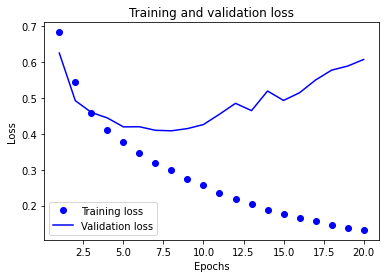

In [86]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

-------------------------------------------------------------------------------------------------------------

# 회고

    [ 처음엔 오!! 나중엔 오.. ]

처음 프로젝트를 받았을 때, 아무래도 저번의 작사 NLP보다 감성분석 쪽이라 실생활에 적용하기도 좋을 것같아서 재밌어보였습니다. 제가 만만하게 본게 실수였는지 통틀어 가장 어려웠던, 집에 가는 길에 깊은 고뇌에 바쪘던 프로젝트였습니다. 그래도 포기할 순 없으니 해야 했습니다.

저의 프로젝트 모델에서 'word2vec'을 임베딩해준 후 성능의 차이는 크게 보이지 않았지만, Loss와 Accuracy 그래프를 시각화한 것을 보면 사용하지 않았을 때보다 사용한 모델이 오버피팅이 잘 잡혔음을 확인할 수 있습니다.

사실 더 많은 모델도 구현하려고 했으나 실패했습니다. 그 이유는 하나부터 일곱?정도까지 이해가 부족했기 때문입니다. 부족한 부분을 알게 된 지금부터라도 조금 더 다듬은 후 다시 돌아와 완성할 것입니다.

성장한 내가 잘 해결해주길!